In [1]:
# import packages/libraries 
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import joblib

In [2]:
# import data
df = pd.read_csv("C:\Data science\ExcelR Project\\Churn.csv")
df.head()

,Unnamed: 0,state,area.code,account.length,voice.plan,voice.messages,intl.plan,intl.mins,intl.calls,intl.charge,...,day.calls,day.charge,eve.mins,eve.calls,eve.charge,night.mins,night.calls,night.charge,customer.calls,churn
0,1,KS,area_code_415,128,yes,25,no,10.0,3,2.70,...,110,45.07,197.4,99,16.78,244.7,91,11.01,1,no
1,2,OH,area_code_415,107,yes,26,no,13.7,3,3.70,...,123,27.47,195.5,103,16.62,254.4,103,11.45,1,no
2,3,NJ,area_code_415,137,no,0,no,12.2,5,3.29,...,114,41.38,121.2,110,10.30,162.6,104,7.32,0,no
3,4,OH,area_code_408,84,no,0,yes,6.6,7,1.78,...,71,50.9,61.9,88,5.26,196.9,89,8.86,2,no
4,5,OK,area_code_415,75,no,0,yes,10.1,3,2.73,...,113,28.34,148.3,122,12.61,186.9,121,8.41,3,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      5000 non-null   int64  
 1   state           5000 non-null   object 
 2   area.code       5000 non-null   object 
 3   account.length  5000 non-null   int64  
 4   voice.plan      5000 non-null   object 
 5   voice.messages  5000 non-null   int64  
 6   intl.plan       5000 non-null   object 
 7   intl.mins       5000 non-null   float64
 8   intl.calls      5000 non-null   int64  
 9   intl.charge     5000 non-null   float64
 10  day.mins        5000 non-null   float64
 11  day.calls       5000 non-null   int64  
 12  day.charge      5000 non-null   object 
 13  eve.mins        5000 non-null   object 
 14  eve.calls       5000 non-null   int64  
 15  eve.charge      5000 non-null   float64
 16  night.mins      5000 non-null   float64
 17  night.calls     5000 non-null   i

In [4]:
# Drop unnamed column
df = df.drop(columns=['Unnamed: 0'])

In [5]:
# Rename columns
df = df.rename({'area.code':'area_code','account.length':'account_length','voice.plan':'voice_plan',
                  'voice.messages':'voice_messages','intl.plan':'intl_plan','intl.mins':'intl_mins','intl.calls':'intl_calls',
                  'intl.charge':'intl_charge','day.mins':'day_mins','day.calls':'day_calls',
                  'day.charge':'day_charge','eve.mins':'eve_mins','eve.calls':'eve_calls',
                  'eve.charge':'eve_charge','night.mins':'night_mins','night.calls':'night_calls',
                  'night.charge':'night_charge','customer.calls':'customer_calls'}, axis= 1)

In [6]:
# To find duplicate rows
df.duplicated().sum()

0

In [7]:
# To find null values
df.isna().sum()

state             0
area_code         0
account_length    0
voice_plan        0
voice_messages    0
intl_plan         0
intl_mins         0
intl_calls        0
intl_charge       0
day_mins          0
day_calls         0
day_charge        0
eve_mins          0
eve_calls         0
eve_charge        0
night_mins        0
night_calls       0
night_charge      0
customer_calls    0
churn             0
dtype: int64

In [8]:
# Convert Object columns to float,replace Nan with mean (Imputation)
df['day_charge'] = pd.to_numeric(df['day_charge'], 'coerce').pipe(lambda s: s.fillna(s.mean()))
df['eve_mins'] = pd.to_numeric(df['eve_mins'], 'coerce').pipe(lambda s: s.fillna(s.mean()))

In [9]:
# Feature engineering
# Using EDA most significant features are selected for the model building
# Categorical: state [0], voice_plan[3], intl_plan[5], churn[19] 
# numerical: voice_messages[4], intl_charge[8],
# day_charge[11], eve_charge[14], night_charge[17], customer_calls[18]

In [10]:
# Encoding categorical variables
LE = LabelEncoder()
df.iloc[:, 0] = LE.fit_transform(df.iloc[:, 0])
df.iloc[:, 3] = LE.fit_transform(df.iloc[:, 3])
df.iloc[:, 5] = LE.fit_transform(df.iloc[:, 5])
df.iloc[:, 19] = LE.fit_transform(df.iloc[:, 19])

In [11]:
# Scaling numerical variables
idx_num = [4,8,11,14,17,18]
MM = MinMaxScaler()
df[df.columns[idx_num]] = MM.fit_transform(df[df.columns[idx_num]])

In [12]:
df.head()

,state,area_code,account_length,voice_plan,voice_messages,intl_plan,intl_mins,intl_calls,intl_charge,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,customer_calls,churn
0,16,area_code_415,128,1,0.480769,0,10.0,3,0.500000,265.1,110,0.754183,197.4,99,0.542866,244.7,91,0.619584,0.111111,0
1,35,area_code_415,107,1,0.500000,0,13.7,3,0.685185,161.6,123,0.459672,195.5,103,0.537690,254.4,103,0.644344,0.111111,0
2,31,area_code_415,137,0,0.000000,0,12.2,5,0.609259,243.4,114,0.692436,121.2,110,0.333225,162.6,104,0.411930,0.000000,0
3,35,area_code_408,84,0,0.000000,1,6.6,7,0.329630,299.4,71,0.851740,61.9,88,0.170171,196.9,89,0.498593,0.222222,0
4,36,area_code_415,75,0,0.000000,1,10.1,3,0.505556,166.7,113,0.474230,148.3,122,0.407959,186.9,121,0.473270,0.333333,0


In [13]:
# Balancing the dataset
# churn variable class count
class_count_0, class_count_1 = df['churn'].value_counts()

# Separate class
class_0 = df[df['churn'] == 0]
class_1 = df[df['churn'] == 1]
# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (4293, 20)
class 1: (707, 20)


total class of 1 and 0: 1    4293
0    4293
Name: churn, dtype: int64


<AxesSubplot: title={'center': 'count (target)'}>

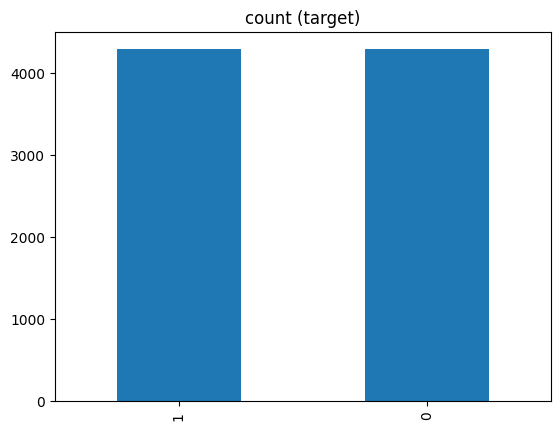

In [14]:
# Balancing the dataset: Random over sampling method
class_1_over = class_1.sample(class_count_0, replace=True)

test_over = pd.concat([class_1_over, class_0], axis=0)

print("total class of 1 and 0:",test_over['churn'].value_counts())# plot the count after under-sampling
test_over['churn'].value_counts().plot(kind='bar', title='count (target)')

In [15]:
test_over.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8586 entries, 1280 to 4999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   state           8586 non-null   int32  
 1   area_code       8586 non-null   object 
 2   account_length  8586 non-null   int64  
 3   voice_plan      8586 non-null   int32  
 4   voice_messages  8586 non-null   float64
 5   intl_plan       8586 non-null   int32  
 6   intl_mins       8586 non-null   float64
 7   intl_calls      8586 non-null   int64  
 8   intl_charge     8586 non-null   float64
 9   day_mins        8586 non-null   float64
 10  day_calls       8586 non-null   int64  
 11  day_charge      8586 non-null   float64
 12  eve_mins        8586 non-null   float64
 13  eve_calls       8586 non-null   int64  
 14  eve_charge      8586 non-null   float64
 15  night_mins      8586 non-null   float64
 16  night_calls     8586 non-null   int64  
 17  night_charge    8586 non-null 

In [16]:
# Assigning X, Y 

X = test_over.iloc[:, [0,3,4,5,8,11,14,17,18]]
y = test_over.iloc[:, [-1]]

In [17]:
# X, y splitting into train, test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [18]:
# train portion value counts of churn in percent
y_train.value_counts(normalize=True).mul(100).round(2)

churn
0        50.1
1        49.9
dtype: float64

In [19]:
# test portion value counts of churn in percent
y_test.value_counts(normalize=True).mul(100).round(2)

churn
1        50.23
0        49.77
dtype: float64

In [20]:
# XG Boost Classifier

xgb = XGBClassifier(n_estimators = 100, gamma=1, reg_lambda=0.5)
              
xgb.fit(X_train, y_train)

y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

# Metrics
ac1_xgb = accuracy_score(y_train, y_pred_train)
ac2_xgb = accuracy_score(y_test, y_pred_test)
print("Training accuracy:", ac1_xgb.round(3)*100)
print("Test accuracy:", ac2_xgb.round(2)*100)

Training accuracy: 99.9
Test accuracy: 98.0


In [21]:
# Model evalation: K-Fold METHOD
kfold = KFold(n_splits=5)

results = abs(cross_val_score(xgb, X_train, y_train, cv=kfold,scoring='neg_mean_squared_error'))
print('neg_mean_squared_error:', np.mean(np.sqrt(results).round(3)))

results = abs(cross_val_score(xgb, X_train, y_train, cv=kfold,scoring='accuracy'))
print('accuracy %:',np.mean(results).round(3)*100)

neg_mean_squared_error: 0.1766
accuracy %: 96.89999999999999


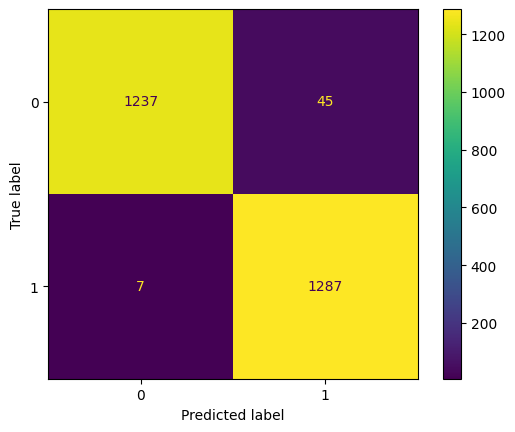

In [22]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test, labels=xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.show()

In [23]:
# Classification metrics
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1282
           1       0.97      0.99      0.98      1294

    accuracy                           0.98      2576
   macro avg       0.98      0.98      0.98      2576
weighted avg       0.98      0.98      0.98      2576



In [24]:
TN = cm[0,0]
TP = cm[1,1]
FP = cm[0,1]
FN = cm[1,0] 

classification_accuracy = (TP+TN) / float(TP+TN+FP+FN)
print('Classification accuracy: {0:0.4f}'.format(classification_accuracy))

classification_error = (FP+FN) / float(TP+TN+FP+FN)
print('Classification error: {0:0.4f}'.format(classification_error))

precision = TP/float(TP+FP)
print('Precision: {0:0.4f}'.format(precision))

recall = TP / float(TP+FN)
print('Recall or Sensitivity : {0:0.4f}'.format(recall))

true_positive_rate = TP / float(TP+FN)
print('True Positive Rate : {0:0.4f}'.format(true_positive_rate))

false_positive_rate = FP / float(FP+TN)
print('False Positive Rate : {0:0.4f}'.format(false_positive_rate))

specificity = TN / (TN+FP)
print('Specificity : {0:0.4f}'.format(specificity))

Classification accuracy: 0.9798
Classification error: 0.0202
Precision: 0.9662
Recall or Sensitivity : 0.9946
True Positive Rate : 0.9946
False Positive Rate : 0.0351
Specificity : 0.9649


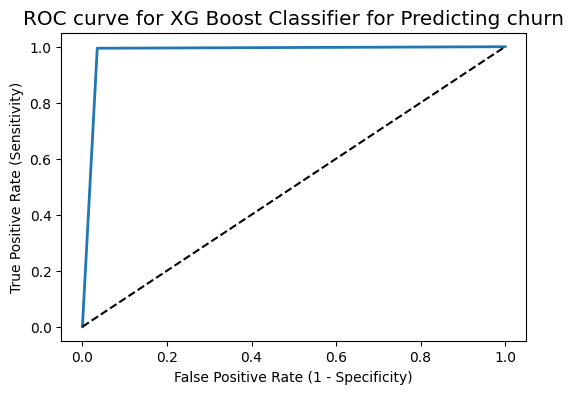

In [25]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for XG Boost Classifier for Predicting churn')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

In [26]:
ROC_AUC = roc_auc_score(y_test, y_pred_test)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.9797


In [28]:
# Save the model to the disk
joblib.dump(xgb, 'xgb_model.pkl')

['xgb_model.pkl']